# Assess the accuracy of the ML models

> **Warning** The "best_score" key inside gridcv stats corresponds to the gridcv validation. This value is different from the balanced accuracy computed inside the best gridcv metrics. The first one is computed with the train sample, and the last one with the test or validation sample.

In [1]:
from pathlib import Path
import sys
import shap
import pickle
import numpy as np
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

# ROOT = r"C:\copia_seguridad\doctorado_v2\classification"
ROOT = r"D:\iranzo\doctorado_v2\classification"

sys.path.append(str(Path(ROOT, 'Python')))
from utils_models import CMatrix as cmatrix # type: ignore
from utils_models import Model, Pipeline, Dataset, Reduction

In [ ]:
graphics_path = Path(ROOT, "papers/RAQRS_journal/figures")

In [2]:
def search_dict(lst: list[dict] | pd.DataFrame, target_dict):

    unique_id_keys = ["pred_id", "model", "pipe", "dataset"]
    pred_id, model, pipe, dataset = [target_dict[k] for k in unique_id_keys]

    if type(lst) == list:
        # Create a generator object to avoid building an intermediate list
        matches = (
            d for d in lst
            if d.get("pred_id") == pred_id
            and d.get("model") == model
            and d.get("pipe") == pipe
            and d.get("dataset") == dataset
        )
        result = list(matches)

        if len(result) == 1:
            return result[0]
        else:
            raise ValueError("There is no unique dict with the requested params.")
    
    else:
        query = f"(pred_id == '{pred_id}') & (model == '{model}') & (pipe_name == '{pipe}')"
        lst.query(query, inplace=True)
        return lst

In [3]:
label_codes = pd.read_csv(Path(ROOT, "data/labels/label_codes.csv"))
# Delete duplicate values in reclass label column
# Note: If the removal is not made, for one label matched two new ones appears.
label_codes = label_codes.groupby('code_v1_reclass', as_index=False).max()

In [4]:
def set_version(dataset_version, lst: list[dict]):
    # Check if the dictionaries inside the list contains the dataset version
    if "dataset" not in lst[0].keys():
        lst = [dict(d, dataset =dataset_version) for d in lst]
    
    return lst

def load_stats(folder_name):
    """Read stats by dataset version."""
    # TODO: Get only the recent one
    folder_path = [i for i in Path(ROOT, r"results/logs").glob(f"{folder_name}*")][0]
    # Extract the dataset version
    dataset_version = int(folder_name[-1])

    with open(Path(folder_path, "gridcv_stats.pkl"), "rb") as f:
        model_grid_stats = pickle.load(f)
        model_grid_stats = set_version(dataset_version, model_grid_stats)
    
    with open(Path(folder_path, "confusion_matrices.pkl"), "rb") as f:
        cm_stats = pickle.load(f)
        cm_stats = set_version(dataset_version, cm_stats)

    grid_best_stats = pd.read_csv(Path(folder_path, "best_gridcv_stats.csv"))
    if "dataset" not in grid_best_stats.columns.to_list():
        grid_best_stats["dataset"] = dataset_version

    # Get the dict with the highest score value
    best_model = max(model_grid_stats, key=lambda x: x["best_score"])

    if best_model["model"] == "svm":
        # It is mandatory to compute the class probability to compute SHAP values in SVM
        best_model["best_params"]["probability"] = True

    return grid_best_stats, cm_stats, best_model

In [5]:
dataset_versions = [1, 2, 3]

best_grids = {}
cm_stats = []
grid_best_stats = []

for v in dataset_versions:
    folder_name = f"train_dataset_v{v}"

    grid_stats, cm_best, best_grid = load_stats(folder_name)
    best_grids[v] = best_grid
    cm_stats.extend(cm_best)
    grid_best_stats.append(grid_stats)

grid_best_stats = pd.concat(grid_best_stats)


In [6]:
best_grids

{1: {'pred_id': 'LseasonPCA_gHSA',
  'model': 'svm',
  'pipe': 'none_tomeklinks',
  'best_params': {'C': 15,
   'degree': 1,
   'gamma': 'scale',
   'kernel': 'rbf',
   'probability': True},
  'best_score': 0.8129365516017499,
  'dataset': 1},
 2: {'pred_id': 'LseasonPCA_gHSA',
  'model': 'svm',
  'pipe': 'none_none',
  'best_params': {'C': 25,
   'gamma': 'scale',
   'kernel': 'rbf',
   'probability': True},
  'best_score': 0.701334985530067,
  'dataset': 2},
 3: {'pred_id': 'Ls_v2',
  'model': 'svm',
  'pipe': 'none_none',
  'best_params': {'C': 25,
   'gamma': 'scale',
   'kernel': 'rbf',
   'probability': True},
  'best_score': 0.7138614973588302,
  'dataset': 3}}

## Pipelines

Ver las métricas de error por pipeline (dividir under and over techniques). Si las que no hacen por hacer la muestra más "umbalanced" puede que las tengan más bajas, citar trabajos que dicen que las muestras poco balanceadas inflan las estadísticas de error.

In [25]:
# Function to plot grouped horizontal bars
def plot_grouped_bars(df, title, ax):
    colors = ["#212529", "#6c757d", "#ced4da"]

    dat_over = df.groupby(["over", "dataset"])["data"].mean().unstack()
    dat_under = df.groupby(["under", "dataset"])["data"].mean().unstack()
    dat = pd.concat([dat_over, dat_under])

    y = range(len(dat.index))
    n_datasets = dat.shape[1]   # number of datasets (2, 3, ...)
    bar_height = 0.8 / n_datasets  # shrink bars so they all fit

    # Loop over datasets
    for i, col in enumerate(dat.columns):
        offset = (i - (n_datasets-1)/2) * bar_height
        ax.barh([yy + offset for yy in y],
                dat[col],
                height=bar_height,
                color = colors[i],
                label=f"Dataset {col}")

    ax.set_yticks(y)
    ax.set_yticklabels(dat.index)
    ax.set_xlabel("Score")

['smote_tomeklinks' 'smote_random' 'smote_none' 'none_tomeklinks'
 'none_random' 'none_none']


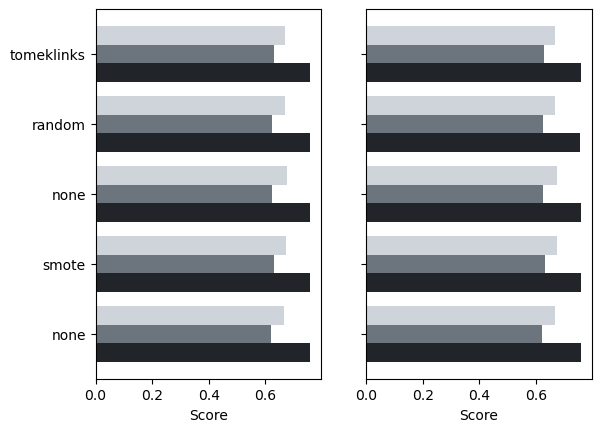

In [26]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

# Split pipeline into oversampling and undersampling
q = f"metric == 'balanced_accuracy'"
dat = grid_best_stats.query(q + " and model == 'rf'").copy()
dat[['over', 'under']] = dat["pipe_name"].str.split('_', expand=True)
plot_grouped_bars(dat, "RF", axs[0])
    
# dat = grid_best_stats.query(q + " and model == 'svm'").copy()
print(pd.unique(dat["pipe_name"]))
dat[['over', 'under']] = dat["pipe_name"].str.split('_', expand=True)
plot_grouped_bars(dat, "SVM", axs[1])

Con los promedios se ve que más o menos son parecidas. Representar las máximas.

In [31]:
q = f"metric == 'balanced_accuracy'"
dat = grid_best_stats.query(q + " and model == 'rf'").copy()
dat[['over', 'under']] = dat["pipe_name"].str.split('_', expand=True)
pivot = (
    dat.groupby(["over", "under"])["data"]
    .max()
    .unstack(fill_value=None)
)
pivot

under,none,random,tomeklinks
over,,,
none,0.876662,0.877376,0.877372
smote,0.891012,0.887992,0.891012


In [32]:
q = f"metric == 'balanced_accuracy'"
dat = grid_best_stats.query(q + " and model == 'svm'").copy()
dat[['over', 'under']] = dat["pipe_name"].str.split('_', expand=True)
pivot = (
    dat.groupby(["over", "under"])["data"]
    .max()
    .unstack(fill_value=None)
)
pivot

under,none,random,tomeklinks
over,,,
none,0.886682,0.886682,0.886682
smote,0.890412,0.884672,0.890412


## Assess scores

Un gráfico por modelo, en el que se observen las métricas de balanced_accuracy en los tres datasets.

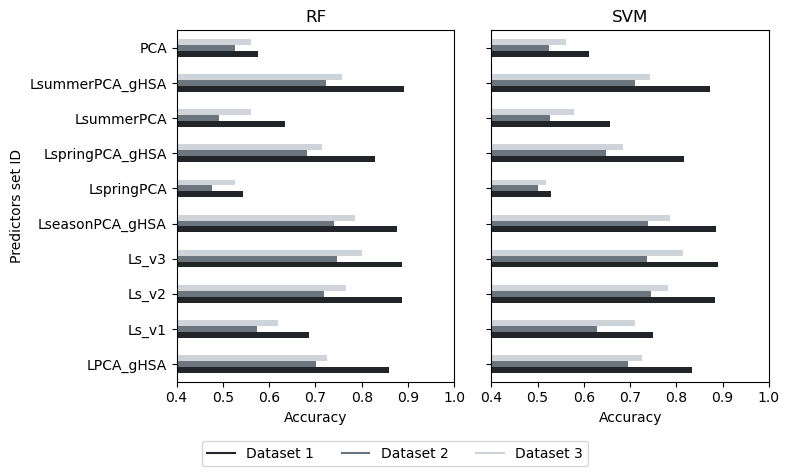

In [11]:
# Plot comparing the two approaches by model and metric
colors = ["#212529", "#6c757d", "#ced4da"]
# colors = ['#a6cee3','#1f78b4','#b2df8a']
fig, axs = plt.subplots(1, 2, figsize=(8,5), sharex=True, sharey=True)
for i, model in enumerate(pd.unique(grid_best_stats["model"])):
    query = f"(label_code.isnull()) and (model == '{model}') and (metric == 'balanced_accuracy')"
    data = grid_best_stats.query(query).groupby(["dataset", "pred_id"]).max().unstack("pred_id")["data"]
    data.T.sort_index().plot(kind="barh", ax=axs[i], color=colors, legend=False)
    axs[i].set_title(model.upper())
    axs[i].set_xlabel("Accuracy")
    axs[i].set_ylabel("Predictors set ID")
    axs[i].set_xlim([.4, 1])

# Cambiar el titulo de "species", son comunidades vegetales
# plt.legend(title="Species")
leg_handles, leg_labels = [], []
for label, color in zip(["Dataset 1", "Dataset 2", "Dataset 3"], colors):
    leg_handles.append(
        axs[0].plot(
            [], [],
            # marker="o",
            color=color,
            label=label
        )[0]
    )
    leg_labels.append(label)

fig.legend(leg_handles, leg_labels, loc='lower center', ncol=8, title='')
plt.tight_layout(rect=[0, 0.06, 1, 0.95])  # Adjust layout to fit global legend
# Save the figure as an SVG file
# plt.savefig(Path(graphics_path, 'dataset_2_overall_metrics_by_pred.svg'), format='svg')

Metrics by pipe name

In [12]:
print("Pipe lines with the best results by dataset and model:")
for k, v in best_grids.items():
    print(k, v["pipe"])

Pipe lines with the best results by dataset and model:
1 none_tomeklinks
2 none_none
3 none_none


> Classification errors for each label were assessed using producer's accuracy and user's accuracy.

Producer's accuracy represents the complement of the omission error (100 minus the ratio of incorrectly classified reference sites to the total reference sites for each label).

User's accuracy reflects the complement of the commission error (100 minus the ratio of incorrectly classified sites to the total classified sites for each label).

In [13]:
# Retrieve the best predictor id by dataset
# and make a query to select only the OA and
fquery = "((model == '{}') and (pred_id == '{}') and (dataset == {}))"
df = grid_best_stats.join(label_codes.set_index("code_v1_reclass")["label_rc_code"], on="label_code")
best_pred_queries = [fquery.format(v["model"], v["pred_id"], k) for k, v in best_grids.items()]
best_pred_queries_str = (" or ").join(best_pred_queries)
cls_err = df.query(best_pred_queries_str).query("metric in ('producer_acc', 'user_acc')")
cls_data = cls_err.groupby(["dataset", "metric", "label_rc_code"]).max()

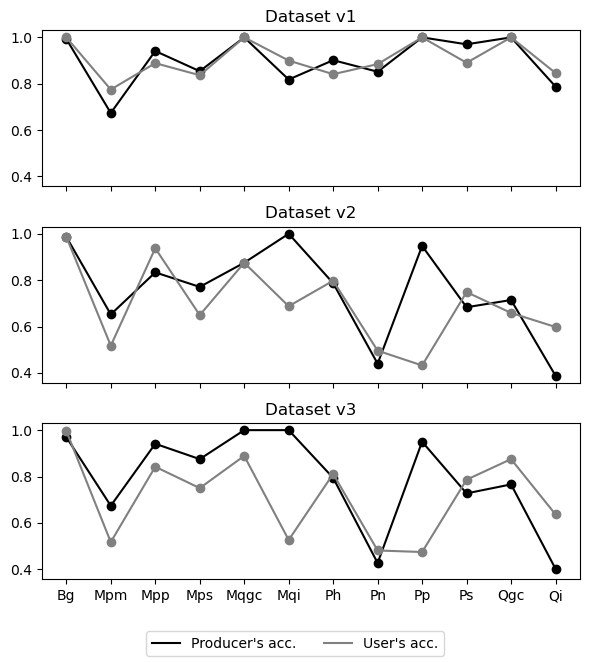

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(6,7), sharey=True, sharex=True)

for i, dataset in enumerate([1, 2, 3]):
    axs[i].plot(cls_data.loc[(dataset, 'producer_acc'), "data"], color="black", marker='o')
    axs[i].plot(cls_data.loc[(dataset, 'user_acc'), "data"], color="grey", marker='o')
    axs[i].set_title(f"Dataset v{i+1}")

# Cambiar el titulo de "species", son comunidades vegetales
# plt.legend(title="Species")
leg_handles, leg_labels = [], []
for label, color in zip(["Producer's acc.", "User's acc."], ["black", "grey"]):
    leg_handles.append(
        axs[0].plot(
            [], [],
            # marker="o",
            color=color,
            label=label
        )[0]
    )
    leg_labels.append(label)

fig.legend(leg_handles, leg_labels, loc='lower center', ncol=8, title='')
fig.tight_layout(rect=[0, 0.06, 1, 0.95])  # Adjust layout to fit global legend

## Confusion Matrix

In [15]:
def show_cm(cm_dict, labels):

    # Join confusion matrix label codes with their names
    cm_labels = pd.DataFrame(cm_dict['labels'], columns=["code"])
    cm_labels = cm_labels.join(labels.set_index("code_v1_reclass"), on="code")
    
    # Create a custom dataframe with data and real labels
    cm = pd.DataFrame(cm_dict["cm"],
                      index=cm_labels['label_rc_code'], columns=cm_labels['label_rc_code'])

    title = f"{cm_dict["model"]} | {cm_dict["pipe"]} | {cm_dict["pred_id"]}"
    cmatrix(cm).pp_matrix(cmap="gray_r", fz=7, pred_val_axis='col',
                          figsize=[6, 6], cmtitle=title)

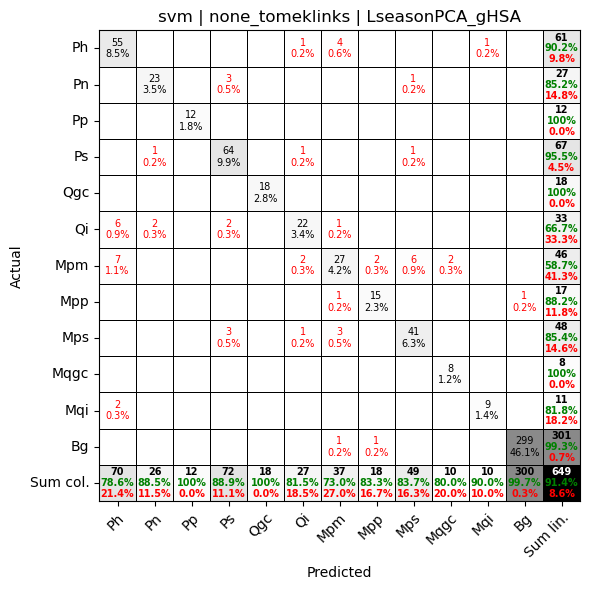

In [16]:
target_cm = search_dict(cm_stats, best_grids[1])
show_cm(target_cm, label_codes)

## SHapley Additive exPlanations

[SHAP](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/shap.html) provides both global feature importance (which features matter most across the dataset) and local explanations (which features drive an individual prediction).

In [83]:
# Import labels and apply pretreatments described in inspect_predictors.ipynb
labels_dataset_path = Path(ROOT, "results/dataset_with_values.gpkg")

dataset = Dataset(labels_dataset_path, 1)

In [33]:
best_grids

{1: {'pred_id': 'LseasonPCA_gHSA',
  'model': 'svm',
  'pipe': 'none_tomeklinks',
  'best_params': {'C': 15,
   'degree': 1,
   'gamma': 'scale',
   'kernel': 'rbf',
   'probability': True},
  'best_score': 0.8129365516017499,
  'dataset': 1},
 2: {'pred_id': 'LseasonPCA_gHSA',
  'model': 'svm',
  'pipe': 'none_none',
  'best_params': {'C': 25,
   'gamma': 'scale',
   'kernel': 'rbf',
   'probability': True},
  'best_score': 0.701334985530067,
  'dataset': 2},
 3: {'pred_id': 'Ls_v2',
  'model': 'svm',
  'pipe': 'none_none',
  'best_params': {'C': 25,
   'gamma': 'scale',
   'kernel': 'rbf',
   'probability': True},
  'best_score': 0.7138614973588302,
  'dataset': 3}}

In [85]:
X_train.columns

Index(['PCAspring_1', 'PCAspring_2', 'PCAspring_3', 'PCAsummer_1',
       'PCAsummer_2', 'PCAsummer_3', 'acibasi', 'dem', 'shadow'],
      dtype='object')

In [84]:
dataset_v = 2
X_train, X_test, y_train, y_test = dataset.split(
    best_grids[dataset_v]["pred_id"], "ESPE_rc")
pred_vars = X_train.columns.to_list()

over, under = best_grids[dataset_v]["pipe"].split("_")
# Construct pipeline
if ("N" in pred_vars) and (over == "smote"):
    pipe = Pipeline(
        y_train,
        under,
        over,
        X_train,
        categorical_predictors=pred_vars["C"])
else:
    pipe = Pipeline(y_train, under, over)

model = Model(best_grids[dataset_v]["model"])
model.add_params(best_grids[dataset_v]["best_params"])
model.get_clf().fit(X_train, y_train)

SVC(C=25, class_weight='balanced', degree=1, probability=True, random_state=42)

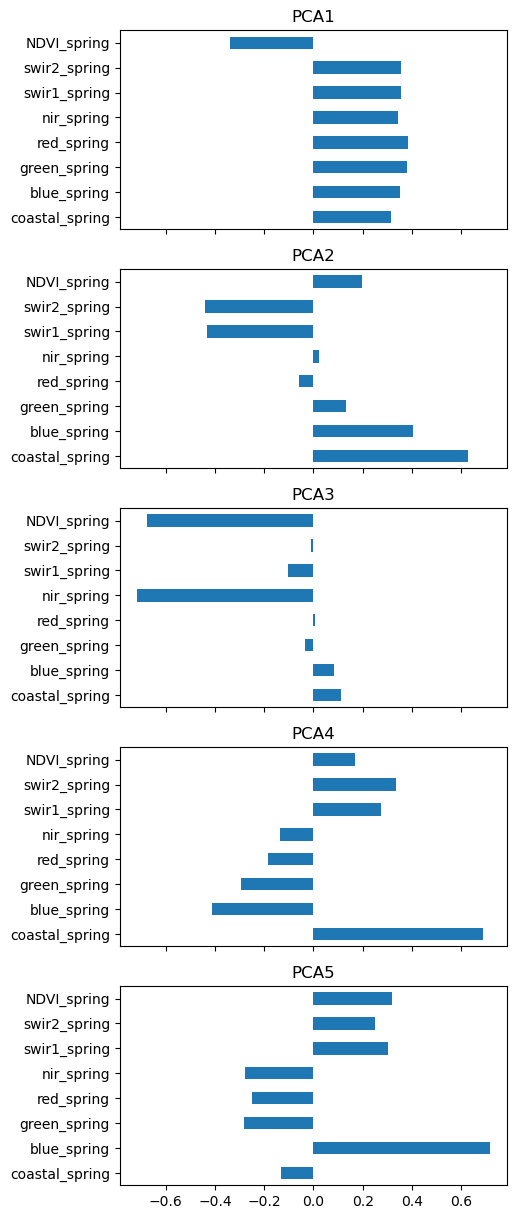

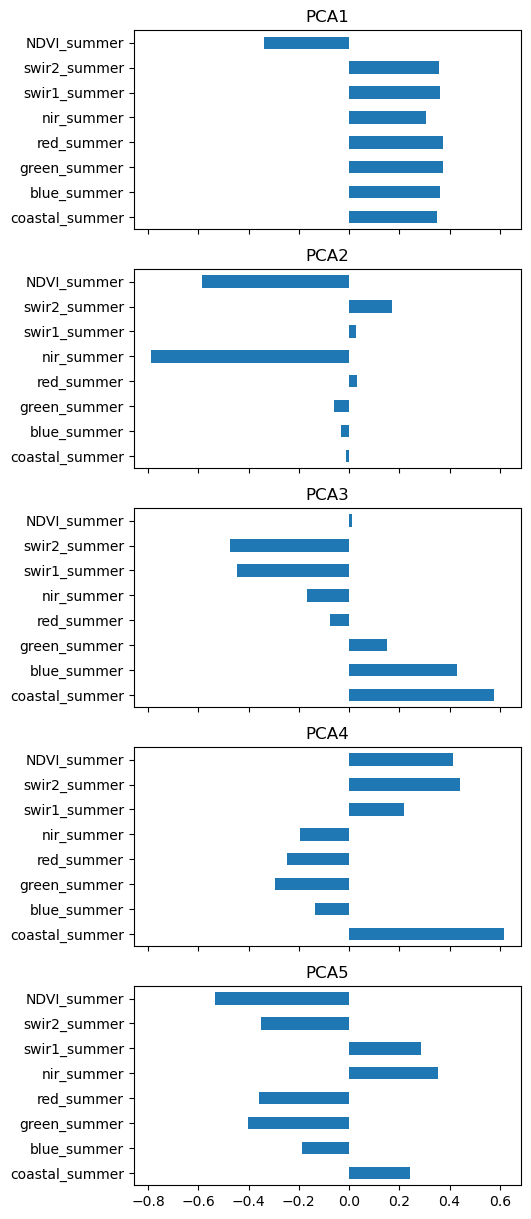

In [86]:
# Select columns used to create PCAs
pred_original_cols = dataset.predictor_sets[best_grids[dataset_v]["pred_id"]]

# Perform the PCA reduction (code inside Dataset.split)
if "PCA" in pred_original_cols.keys():

    for sfx, pca_cols in pred_original_cols["PCA"].items():

        pca = Reduction(dataset.matrix, pca_cols, 'ESPE_rc')
        pca.plot_loadings()


### SVM SHAP

In [87]:
# SHAP doesn’t have a specialized explainer for SVMs.
# KernelExplainer is mandatory, which is model-agnostic but slower
# KernelExplainer (model-agnostic)
explainer = shap.KernelExplainer(model.get_clf().predict_proba, X_train.sample(50, random_state=42))
# background dataset = 50 samples for efficiency

# Compute SHAP values for a subset of test data (computationally expensive)
shap_values = explainer.shap_values(X_test.iloc[:30, :])

  0%|          | 0/30 [00:00<?, ?it/s]

### Tree SHAP

In [28]:
# SHAP has a fast, optimized algorithm for tree classifiers
# SHAP explainer for tree models
explainer = shap.TreeExplainer(model.get_clf())

# Multiclass problem:
# shap_values will be a list with one array per class,
# each of shape (n_samples, n_features)
shap_values = explainer.shap_values(X_train)

### SHAP values

In [115]:
X_train.columns

Index(['PCAspring_1', 'PCAspring_2', 'PCAspring_3', 'PCAsummer_1',
       'PCAsummer_2', 'PCAsummer_3', 'acibasi', 'dem', 'shadow'],
      dtype='object')

In [131]:
# --- Option 1: aggregate across classes ---
# Take absolute values, mean over samples and classes
mean_abs_shap_per_feature = np.mean(np.abs(shap_values), axis=(0, 2))
max_abs_shap_per_feature = np.max(np.abs(shap_values), axis=(0, 2))

# --- Option 2: keep per-class importance ---
# Take absolute values, mean over samples only
mean_abs_shap_per_feature_class = np.mean(np.abs(shap_values), axis=0)

In [137]:
shap_abs_vals = pd.DataFrame({
    "abs_max": mean_abs_shap_per_feature,
    "abs_mean": max_abs_shap_per_feature
}, index=X_train.columns).sort_values(by=["abs_mean"])

<BarContainer object of 9 artists>

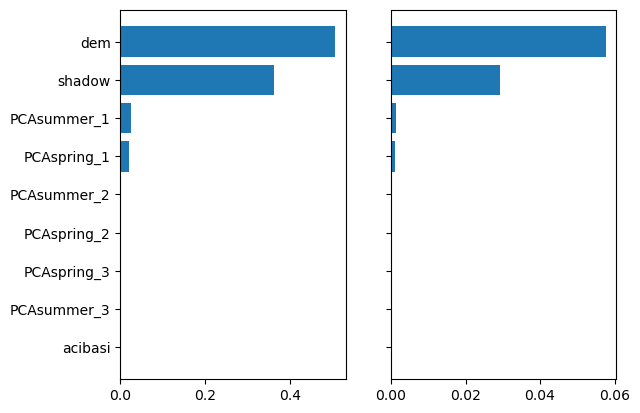

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True)

axs[0].barh(shap_abs_vals.index, shap_abs_vals["abs_mean"])

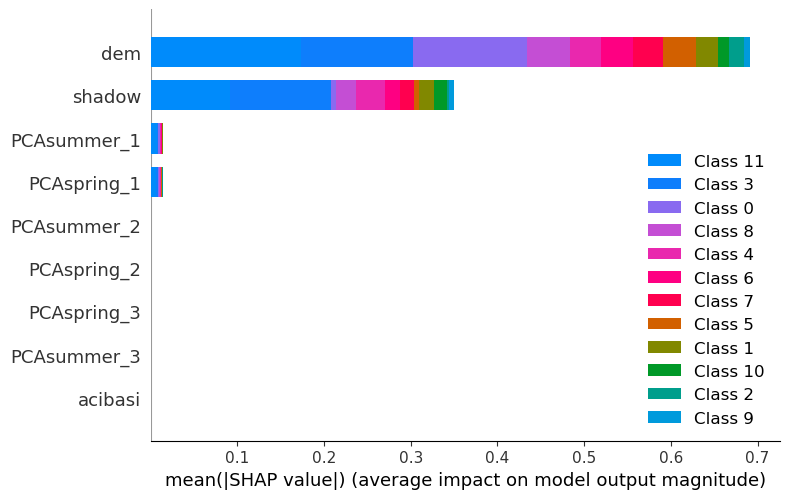

In [89]:
# Global importance bar plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

AssertionError: Feature and SHAP matrices must have the same number of rows!

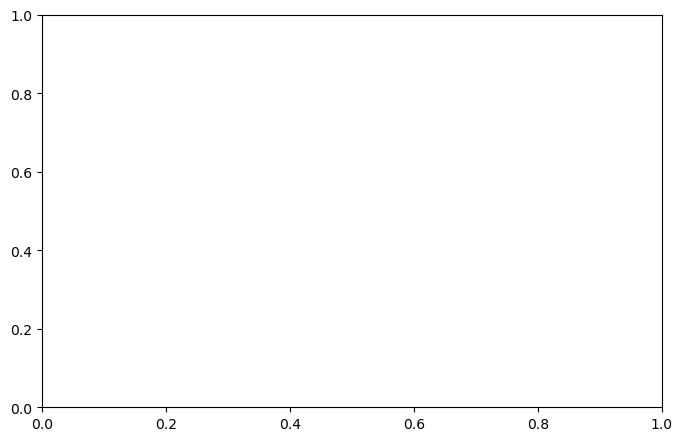

In [64]:
# SHAP values by predicted class
shap.summary_plot(shap_values[:,:,0], X_train)

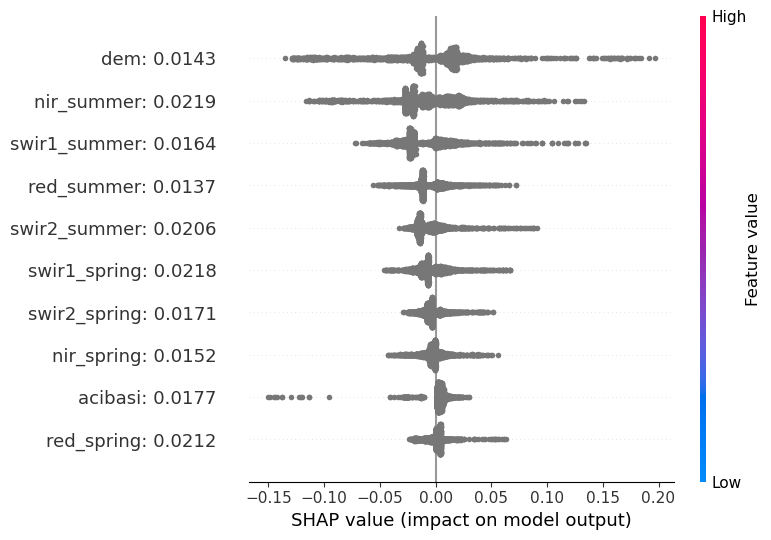

In [ ]:
# The same as above but with mean shap values
feature_names = [
    a + ": " + str(b) for a,b in zip(X_train.columns, mean_abs_shap_overall.round(4))
]

shap.summary_plot(shap_values[:,:,1], X_train, max_display=X_train.shape[1], 
                  feature_names=feature_names)

# shap.summary_plot(shap_values[:,:,0:10], X_train)

In [43]:
# Local explanation, single prediction
# Pick a single instance
i = 0
shap.force_plot(explainer.expected_value[0], shap_values[:, :, 0][i,:], X_train.iloc[i,:])

In order to compute manually the values that `shap.summary_plot(..., plot_type="bar")`:

For `plot_type="bar"` in a multi-class model:

* `shap_values` for a multi-class classifier is **a list of arrays**, one array per class.
* Each array has shape `(n_samples, n_features)` representing the SHAP value of each feature for each sample **for that class**.
* The bar plot shows the **mean absolute SHAP value for each feature**, averaged **over all samples** (and usually per class if multi-class).

So mathematically, for feature $j$:

$$
\text{mean\_abs\_shap}_j = \frac{1}{n_{\text{samples}}} \sum_{i=1}^{n_{\text{samples}}} | \text{shap\_value}_{i,j} |
$$

For multi-class, you often either:

* Plot **per class** (so you compute this per class), or
* Take **the mean across all classes** if you want a single summary bar.

---

### 2️⃣ Compute manually from `shap_values`

Assume:

```python
import shap
import numpy as np

# shap_values is from shap.TreeExplainer(model).shap_values(X_train)
# X_train is your training data
```

If you have multi-class:

```python
# shap_values is a list: one array per class
# Let's compute the 

mean_abs_shap_per_class = [np.abs(class_shap).mean(axis=0) for class_shap in shap_values]

# Now, if you want a single average across all classes:
mean_abs_shap_overall = np.mean(mean_abs_shap_per_class, axis=0)

# mean_abs_shap_overall[i] corresponds to feature i
```

`mean_abs_shap_overall` now contains exactly the data used in the bar plot.

If you want **per class**, just use `mean_abs_shap_per_class[class_idx]`.

---

### 3️⃣ Example with feature names

```python
feature_names = X_train.columns  # if it's a pandas DataFrame

for name, val in zip(feature_names, mean_abs_shap_overall):
    print(f"{name}: {val:.4f}")
```

This gives you the numeric values you can use to create your **custom bar chart** with matplotlib, seaborn, plotly, etc.

---

### ✅ Summary

* Bar plot = **mean absolute SHAP value per feature**.
* Multi-class: either take per-class arrays or average across classes.
* `np.abs(shap_values).mean(axis=0)` gives the mean absolute value per feature.

---

If you want, I can also give you a **ready-to-use snippet to make a custom bar plot** that mimics `shap.summary_plot(..., plot_type="bar")` exactly, including sorting the features by importance.

Do you want me to do that?
